<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/NoteBook/Spatial_interpolation/cokriging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Co-kriging in R**

Zia Ahmed, Unversity Buffalo

Co-Kriging (CK),  also known as Co-estimation or Co-regionalization, is a geostatistical technique that involves the addition of other observed variables (commonly referred to as co-variates, which are often related to the variables of interest) to enhance the accuracy of the kriging of the variables of interest. It is particularly valuable when you have two or more interrelated variables that exhibit spatial dependence, and you want to leverage the information from one variable to improve the estimation of another variable. Unlike regression and universal kriging, Co-Kriging does not require that the secondary information is available at all prediction locations. The co-variable may be measured at the same points as the target (co-located samples), at other points, or both.


Here's a detailed explanation of Co-Kriging:

**Components of Co-Kriging:**

1. **Primary Variable (Z1):** This is the variable of primary interest, and you want to estimate its values at unsampled locations.

2. **Secondary Variable(s) (Z2, Z3, ...):** These are one or more secondary variables that are measured at the same spatial locations as the primary variable. The secondary variables are used to provide additional information that can improve the estimation of the primary variable.

**The Co-Kriging Process:**

Co-Kriging extends the principles of Kriging to estimate the primary variable while taking into account the spatial relationships between the primary and secondary variables. The Co-Kriging estimation equation can be expressed as:

Z1(u) = μ1 + λ1 * [Z2(u) - μ2] + λ2 * [Z3(u) - μ3] + ...

Where:
- Z1(u) is the estimated value of the primary variable at the unsampled location u.
- μ1 is the global mean of the primary variable (Z1).
- λ1, λ2, ... are the kriging weights assigned to the secondary variables (Z2, Z3, ...) at location u.
- μ2, μ3, ... are the global means of the secondary variables (Z2, Z3, ...).

**The Co-Kriging Variance:**

Just like in traditional Kriging, Co-Kriging provides a kriging variance, which quantifies the uncertainty associated with the estimate of the primary variable at each unsampled location. Smaller kriging variances indicate more reliable estimates.

**Steps in Co-Kriging:**

1. **Data Preparation:** You start with a dataset that includes measurements of multiple variables (both primary and secondary) at various spatial locations.

2. **Variogram Analysis:** Calculate and model variograms for all variables involved. Variograms are used to quantify the spatial autocorrelation or spatial dependence of each variable.

3. **Cross-Variograms:** Calculate cross-variograms to quantify the spatial cross-correlation between the primary variable and each of the secondary variables. These cross-variograms help establish the relationships between the variables.  The cross-variogram is calculated to understand how changes in the secondary variable(s) relate to changes in the primary variable at different distances and directions.

4. **Kriging Weights:** Determine the kriging weights for each variable, including the primary and secondary variables, using the cross-variograms and variograms. The weights are chosen to minimize the estimation error variance while ensuring the unbiasedness of the estimator.

5. **Estimation:** Use the kriging weights to estimate the values of the primary variable at unsampled locations, while taking into account the information from the secondary variables.

6. **Model Validation:** Validate the Co-Kriging model, including the adequacy of variogram models and the spatial relationships between variables.

Co-Kriging is a powerful technique for improving the accuracy of spatial predictions when you have multiple correlated variables. It is used in various fields such as geology, environmental science, hydrogeology, and agriculture, where understanding the relationship between variables is essential for informed decision-making and accurate predictions.

### Install rpy2

In [1]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.4.2
Uninstalling rpy2-3.4.2:
  Successfully uninstalled rpy2-3.4.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp310-cp310-linux_x86_64.whl size=314929 sha256=1ad6df62655dc8e0672d00e3c3ab72fd62f7872e4e2aa758388f9de08371bcf5
  Stored in directory: /root/.cache/pip/wheels/73/a6/ff/4e75dd1ce1cfa2b9a670cbccf6a1e41c553199e9b25f05d953
Successfully built rpy2


### Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Check and Install Required R Packages

In [ ]:
%%R
pkg <- c('tidyverse', 'tidymodels', 'raster', 'rgdal','terra','tidyterra', 'maptools', 'sf', 'classInt',
         'RColorBrewer', 'tmap','tmaptools', 'gridExtra', 'devtools', 'data.table', 'gstat','Hmisc','corrplot',
         'ggmap','ggpmisc', 'plyr','spatstat','dismo','fields', 'moments', 'car', 'Hmisc')
new.packages <- pkg[!(pkg %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')

### Load R Packages

In [ ]:
%%R
# set library path
.libPaths('drive/My Drive/R')
library (tidyverse)
library (tidymodels)
library (terra)
library (tidyterra)
library(raster)
library(RColorBrewer)
library(RStoolbox)
library(gridExtra)
library(latticeExtra)
library(data.table)
library(gstat)
library(classInt)
library(plyr)
library(spatstat)
library(dismo)
library(fields)
library(moments)
library(car)
library(ggpmisc)
library(Hmisc)

### Data

The following data will be used in the exercise that can be found in my [Dropbox](https://www.dropbox.com/scl/fo/j7322sbo4gdqv8a2rfqry/h?rlkey=fmlnsu08lut4pxf0s4q1jm44a&dl=0) folder.

1. GP_all_data.csv

2. GP_prediction_grid_data.csv

In [9]:
%%R
mf<-read_csv('/content/drive/MyDrive/R_Website/Spatial_Interpolation/Data/GP_all_data.csv')
grid<-read_csv('/content/drive/MyDrive/R_Website/Spatial_Interpolation/Data/GP_prediction_grid_data.csv')

Rows: 471 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): STATE, COUNTY, NLCD_DES, FRG_DES
dbl (17): ID, STATE_ID, FIPS, x, y, SOC, ELEV, Aspect, Slope, TPI, K_Factor,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 10674 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (13): x, y, Aspect, ELEV, FRG, K_Factor, MAP, MAT, NDVI, NLCD, Silt_Clay...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### Data Transformation

First, we have to calculate appropriate transformation parameters using the **powerTransform()** function of the car package and then use this parameter to transform the data using the **bcPower()** function.

In [10]:
%%R
power<-powerTransform(mf$SOC)
lambda<-power$lambda
lambda

   mf$SOC 
0.2905371 


In [11]:
%%R
mf$SOC.bc<-bcPower(mf$SOC,lambda)

In [13]:
%%R
glimpse(mf)

Rows: 471
Columns: 22
$ ID        <dbl> 466, 55, 51, 67, 449, 86, 82, 265, 68, 216, 75, 454, 35, 87,…
$ STATE_ID  <dbl> 20, 35, 8, 35, 20, 35, 35, 35, 35, 35, 35, 20, 35, 35, 35, 5…
$ STATE     <chr> "Kansas", "New Mexico", "Colorado", "New Mexico", "Kansas", …
$ FIPS      <dbl> 20099, 35031, 8033, 35003, 20019, 35003, 35003, 35015, 35017…
$ COUNTY    <chr> "Labette County", "McKinley County", "Dolores County", "Catr…
$ x         <dbl> 45935.33, -1137299.01, -1106344.79, -1145173.13, -19769.53, …
$ y         <dbl> 1580239, 1446994, 1716869, 1281595, 1552489, 1322861, 123920…
$ SOC       <dbl> 7.256, 4.594, 5.995, 11.220, 5.388, 1.619, 3.842, 10.276, 0.…
$ ELEV      <dbl> 272.6797, 2261.7820, 2404.1121, 2281.4246, 277.6634, 2317.49…
$ Aspect    <dbl> 185.0404, 222.3785, 183.5729, 173.1285, 168.1043, 193.8056, …
$ Slope     <dbl> 1.429968, 4.874323, 6.680480, 7.745950, 2.923675, 2.635038, …
$ TPI       <dbl> 1.0744587, -1.4409482, 7.7656183, -3.2823703, -0.4226714, -1…
$ K_Factor  <dbl> 

### **Correlation matrix**

Before fitting a Co-Kriging model, we must explore the correlation between the target variable (SOC) and other environmental co-variate. Then we will select one variable showing the highest relationship with SOC for Co-kriging.

In [14]:
%%R
df.cor <- mf[, c(22, 9:17)] %>%
glimpse()

Rows: 471
Columns: 10
$ SOC.bc    <dbl> 2.67966970, 1.91840312, 2.34938476, 3.50610617, 2.17252329, …
$ ELEV      <dbl> 272.6797, 2261.7820, 2404.1121, 2281.4246, 277.6634, 2317.49…
$ Aspect    <dbl> 185.0404, 222.3785, 183.5729, 173.1285, 168.1043, 193.8056, …
$ Slope     <dbl> 1.429968, 4.874323, 6.680480, 7.745950, 2.923675, 2.635038, …
$ TPI       <dbl> 1.0744587, -1.4409482, 7.7656183, -3.2823703, -0.4226714, -1…
$ K_Factor  <dbl> 0.3255294, 0.2486000, 0.0590000, 0.2847475, 0.3750685, 0.249…
$ MAP       <dbl> 1099.3408, 410.5008, 568.7746, 391.4978, 1013.7034, 368.2008…
$ MAT       <dbl> 13.748117, 8.162200, 6.890750, 8.533788, 14.152466, 8.189600…
$ NDVI      <dbl> 0.6943141, 0.3705533, 0.6434158, 0.3530265, 0.7292835, 0.283…
$ Silt_Clay <dbl> 77.16470, 40.66200, 53.73600, 46.83738, 62.83973, 38.42100, …


In [15]:
%%R
# Corelation matrix
cor.matrix <- rcorr(as.matrix(df.cor))
cor.matrix

          SOC.bc  ELEV Aspect Slope   TPI K_Factor   MAP   MAT  NDVI Silt_Clay
SOC.bc      1.00  0.11   0.07  0.36  0.04    -0.05  0.53 -0.34  0.63      0.29
ELEV        0.11  1.00   0.22  0.70  0.00    -0.56 -0.31 -0.81 -0.07     -0.50
Aspect      0.07  0.22   1.00  0.28  0.01    -0.12  0.13 -0.19  0.10     -0.08
Slope       0.36  0.70   0.28  1.00 -0.01    -0.51  0.15 -0.64  0.31     -0.21
TPI         0.04  0.00   0.01 -0.01  1.00    -0.03  0.15  0.01  0.08     -0.02
K_Factor   -0.05 -0.56  -0.12 -0.51 -0.03     1.00  0.10  0.37 -0.07      0.59
MAP         0.53 -0.31   0.13  0.15  0.15     0.10  1.00  0.06  0.81      0.47
MAT        -0.34 -0.81  -0.19 -0.64  0.01     0.37  0.06  1.00 -0.21      0.29
NDVI        0.63 -0.07   0.10  0.31  0.08    -0.07  0.81 -0.21  1.00      0.32
Silt_Clay   0.29 -0.50  -0.08 -0.21 -0.02     0.59  0.47  0.29  0.32      1.00

n= 471 


P
          SOC.bc ELEV   Aspect Slope  TPI    K_Factor MAP    MAT    NDVI  
SOC.bc           0.0141 0.1355 0.0000 0.349

### Data Split

In [16]:
%%R
# Split data
set.seed(1245)   # for reproducibility
split <- initial_split(mf, prop = 0.8, strata = SOC.bc)
train <- split %>% training()
test <-  split %>% testing()

In [17]:
%%R
df.xy<-mf %>% dplyr::select(x, y, SOC, SOC.bc, NDVI)
train.xy<-train %>% dplyr::select(x, y, SOC, SOC.bc, NDVI)
test.xy<-test %>% dplyr::select(x, y, SOC, SOC.bc, NDVI)
grid.xy<-grid %>% dplyr::select(x,y)

### Define x & y variables to coordinates

In [18]:
%%R
coordinates(train.xy) = ~x+y
coordinates(test.xy) = ~x+y
coordinates(grid.xy) = ~x+y

## **Variogram Modeling of Co-regionalisation or Corss-Varoigram**

If you look at the correlation analysis, you'll see that only the NDVI has the strongest correlation with the SOC (r=0.64 with a p=0.001). So, we'll use NDVI as a covariates for CK analysis. First, we will model the spatial structure of the SOC, the NDVI, and its covariance with the target variable (SOC), known as 'co-regionalization.'  It measures the spatial cross-correlation or spatial covariance between these two variables.

### 1. Varoigram of target variable (SOC)

In [19]:
%%R
# Variogram
v.soc<-variogram(SOC.bc~ 1, data = train.xy, cloud=F)
# Intial parameter set by eye esitmation
m.soc<-vgm(1.5,"Exp",400000,0.5)
# least square fit
m.f.soc<-fit.variogram(v.soc, m.soc)
p1<-plot(v.soc, pl=F, model=m.f.soc, main= "Varogram of SOC")

### 2. Variogram of Co-Variable (NDVI)

In [20]:
%%R
# Variogram
v.ndvi<-variogram(NDVI~ 1, data = train.xy, cloud=F)
# Intial parameter set by eye esitmation
m.ndvi<-vgm(1.5,"Exp",40000,0.5)
# least square fit
m.f.ndvi<-fit.variogram(v.ndvi, m.ndvi)
p2<-plot(v.ndvi, pl=F, model=m.f.ndvi, main="Variogram of NDVI")

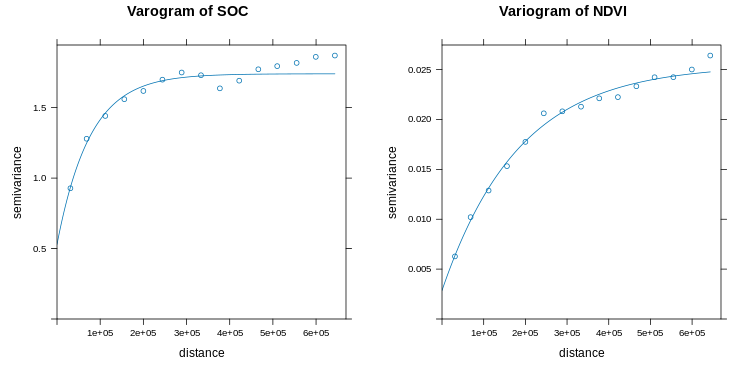

In [21]:
%%R -w 750 -h 375 -u px
grid.arrange(p1, p2, ncol = 2)  # Multiplot


### 3. Cross-variogram

To model Cross-Variogram, we must fit the models to both Direct and cross-varigram simultaneously with the same range but with different partial sill and nuggets.

To model Cross-Varoigram, we must build A **gstat**  object sequentially, using **gstat** package. First, we build a **gstat** structure for the target (SOC) and covariates (NDVI). Then, we will fit variogram models to this **gstat** object.

In [22]:
%%R
g <- gstat(NULL, id = "SOC", form = SOC.bc ~ 1, data=train.xy)
g <- gstat(g, id = "NDVI", form = NDVI ~ 1, data=train.xy)

Display the two direct variograms and one cross-variogram:

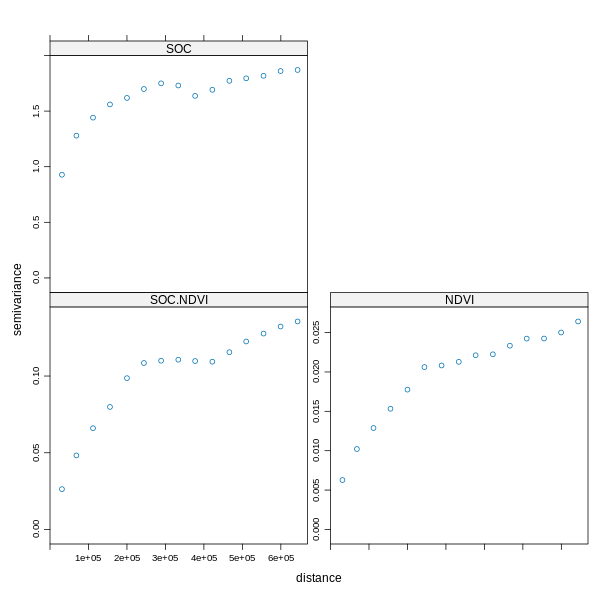

In [23]:
%%R -w 600 -h 600 -u px
v.cross <- variogram(g)
plot(v.cross, pl=F)

### 4. Fit variogram models

We will add variogram models to the **gstat** object and fit them using the linear model of **co-regionalization**. These conditions are automatically met by fitting all the empirical models with one type model (using the fill. all = T argument).

In [24]:
%%R
g <- gstat(g, id = "SOC", model = m.f.soc, fill.all=T)
g

data:
SOC : formula = SOC.bc`~`1 ; data dim = 375 x 3
NDVI : formula = NDVI`~`1 ; data dim = 375 x 3
variograms:
            model     psill    range
SOC[1]        Nug 0.5295042     0.00
SOC[2]        Exp 1.2106243 76177.38
NDVI[1]       Nug 0.5295042     0.00
NDVI[2]       Exp 1.2106243 76177.38
SOC.NDVI[1]   Nug 0.5295042     0.00
SOC.NDVI[2]   Exp 1.2106243 76177.38


Combining the three variograms is necessary to ensure that they result in a co-regionalized positive definite system. To achieve this, the **fit.lmc** method is employed. This method involves the initial estimation, fitting all three variograms, and adjusting each partial sill (i.e., minimum squares) to the nearest value that results in the positive definite matrices.

In [25]:
%%R
g <- fit.lmc(v.cross, g,  fit.method=6, correct.diagonal=1.01)
g

data:
SOC : formula = SOC.bc`~`1 ; data dim = 375 x 3
NDVI : formula = NDVI`~`1 ; data dim = 375 x 3
variograms:
            model        psill    range
SOC[1]        Nug  0.499030160     0.00
SOC[2]        Exp  1.283384093 76177.38
NDVI[1]       Nug  0.002960408     0.00
NDVI[2]       Exp  0.022331550 76177.38
SOC.NDVI[1]   Nug -0.038055533     0.00
SOC.NDVI[2]   Exp  0.154810518 76177.38


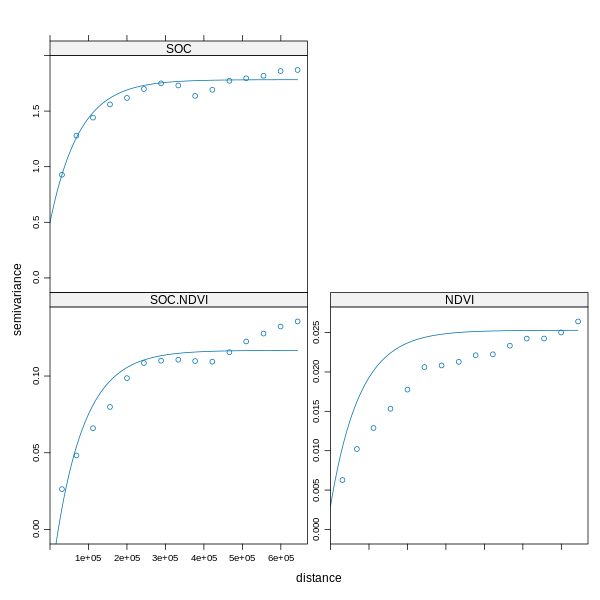

In [26]:
%%R -w 600 -h 600 -u px
plot(variogram(g), model=g$model)


###  **CK Cross-validation**

We have used the **krig.cv()** function for cross-validation of the univariate (OK) case, but for CK, we need to use **gstat.cv()** for the cross-validation of any gstat object. We don’t need to specify a model because it is already stored as part of a gstat object.

In [ ]:
%%R
cv.ck <- gstat.cv(g)

In [28]:
%%R
summary(cv.ck)

Object of class SpatialPointsDataFrame
Coordinates:
       min        max
x -1246454   95251.19
y  1038971 2518794.48
Is projected: NA 
proj4string : [NA]
Number of points: 375
Data attributes:
    SOC.pred          SOC.var          observed         residual        
 Min.   :-0.4774   Min.   :0.5126   Min.   :-2.979   Min.   :-3.500191  
 1st Qu.: 1.3632   1st Qu.:0.9304   1st Qu.: 1.176   1st Qu.:-0.623198  
 Median : 1.9639   Median :0.9957   Median : 2.030   Median :-0.004896  
 Mean   : 2.0301   Mean   :0.9807   Mean   : 2.039   Mean   : 0.008844  
 3rd Qu.: 2.7871   3rd Qu.:1.0545   3rd Qu.: 2.998   3rd Qu.: 0.658880  
 Max.   : 4.1406   Max.   :1.1920   Max.   : 5.846   Max.   : 3.059392  
     zscore               fold      
 Min.   :-3.862787   Min.   :  1.0  
 1st Qu.:-0.631007   1st Qu.: 94.5  
 Median :-0.004850   Median :188.0  
 Mean   : 0.004514   Mean   :188.0  
 3rd Qu.: 0.679076   3rd Qu.:281.5  
 Max.   : 3.034823   Max.   :375.0  


In [29]:
%%R
# ME
mean(cv.ck$residual)
# RMAE
RMSE<-sqrt(mean(cv.ck$residual^2))
RMSE


[1] 1.024483


### **CK validation with an test data set**

**Krige()** function is only valid for univariate Kriging. In this case, we need to use the **predict()** function. The first argument to this function is the gstat object and the second argument is the prediction point data frame.

In [30]:
%%R
CK.test <- predict(g, test.xy)
summary(CK.test)

Linear Model of Coregionalization found. Good.
[using ordinary cokriging]
Object of class SpatialPointsDataFrame
Coordinates:
       min        max
x -1219348   70606.76
y  1019863 2526240.55
Is projected: NA 
proj4string : [NA]
Number of points: 96
Data attributes:
    SOC.pred           SOC.var         NDVI.pred         NDVI.var       
 Min.   :-0.03623   Min.   :0.7350   Min.   :0.1808   Min.   :0.006512  
 1st Qu.: 1.31761   1st Qu.:0.9219   1st Qu.:0.3103   1st Qu.:0.009909  
 Median : 1.82922   Median :1.0231   Median :0.4039   Median :0.011702  
 Mean   : 1.96588   Mean   :1.0341   Mean   :0.4236   Mean   :0.011886  
 3rd Qu.: 2.52655   3rd Qu.:1.1410   3rd Qu.:0.5134   3rd Qu.:0.013797  
 Max.   : 4.17236   Max.   :1.5500   Max.   :0.7274   Max.   :0.021106  
  cov.SOC.NDVI      
 Min.   :-0.019106  
 1st Qu.: 0.005678  
 Median : 0.018832  
 Mean   : 0.019875  
 3rd Qu.: 0.033650  
 Max.   : 0.086268  


In [33]:
%%R
# compute residuls
test.xy$residual <- CK.test$SOC.pred  - test$SOC.bc
test.xy$SOC.pred <- CK.test$SOC.pred

In [34]:
%%R
# Mean Error (ME)
ME<-round(mean(test.xy$residual),3)
# Mean Absolute Error
MAE<-round(mean(abs(test.xy$residual)),3)
# Root Mean Squre Error (RMSE)
RMSE<-round(sqrt(mean(test.xy$residual^2)),3)
RMSE

[1] 1.084


`geom_smooth()` using formula = 'y ~ x'


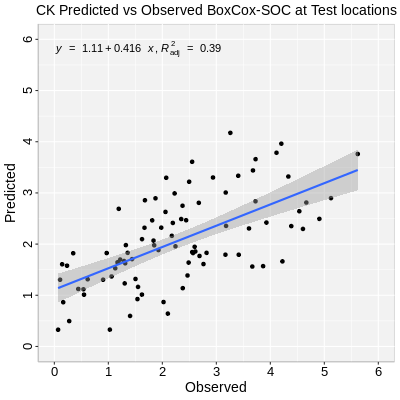

In [35]:
%%R -w 400 -h 400 -u px

test.df<-as.data.frame(test.xy)

formula<-y~x

ggplot(test.df, aes(SOC.bc,SOC.pred)) +
  geom_point() +
  geom_smooth(method = "lm")+
  stat_poly_eq(use_label(c("eq", "adj.R2")), formula = formula) +
  ggtitle("CK Predicted vs Observed BoxCox-SOC at Test locations") +
  xlab("Observed") + ylab("Predicted") +
  scale_x_continuous(limits=c(0,6), breaks=seq(0, 6, 1))+
  scale_y_continuous(limits=c(0,6), breaks=seq(0, 6, 1)) +
  theme(
    panel.background = element_rect(fill = "grey95",colour = "gray75",size = 0.5, linetype = "solid"),
    axis.line = element_line(colour = "grey"),
    plot.title = element_text(size = 14, hjust = 0.5),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text.x=element_text(size=13, colour="black"),
    axis.text.y=element_text(size=13,angle = 90,vjust = 0.5, hjust=0.5, colour='black'))

### **Co-Kriging prediction at grid locations**

**Krige()** function is only valid for univariate Kriging. In this case, we need to use the **predict()** function. The first argument to this function is the gstat object and the second argument is the prediction point data frame.

In [37]:
%%R
CK <- predict(g, grid.xy)

Linear Model of Coregionalization found. Good.
[using ordinary cokriging]


In [ ]:
%%R
summary(CK)

Object of class SpatialPointsDataFrame
Coordinates:
       min     max
x -1245285  114715
y  1003795 2533795
Is projected: NA 
proj4string : [NA]
Number of points: 10674
Data attributes:
    SOC.pred          SOC.var         NDVI.pred         NDVI.var       
 Min.   :-0.7209   Min.   :0.6478   Min.   :0.1355   Min.   :0.001725  
 1st Qu.: 1.2651   1st Qu.:0.9130   1st Qu.:0.3061   1st Qu.:0.006549  
 Median : 1.9124   Median :1.0174   Median :0.4057   Median :0.008412  
 Mean   : 1.9804   Mean   :1.0380   Mean   :0.4157   Mean   :0.008767  
 3rd Qu.: 2.6616   3rd Qu.:1.1354   3rd Qu.:0.5093   3rd Qu.:0.010521  
 Max.   : 4.6013   Max.   :1.6712   Max.   :0.7893   Max.   :0.019998  
  cov.SOC.NDVI      
 Min.   :-0.032279  
 1st Qu.: 0.002888  
 Median : 0.016347  
 Mean   : 0.018803  
 3rd Qu.: 0.031461  
 Max.   : 0.099355  


### Back transformation

In [38]:
%%R
# Back transformation
k<-1/lambda
CK$CK.pred <-((CK$SOC.pred *lambda+1)^k)
CK$CK.var <-((CK$SOC.var *lambda+1)^k)


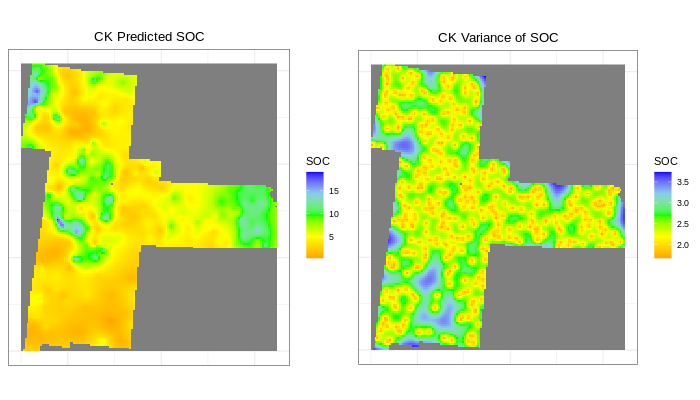

In [39]:
%%R -w 700 -h 400 -u px

CK.pred<-rasterFromXYZ(as.data.frame(CK)[, c("x", "y", "CK.pred")])
CK.var<-rasterFromXYZ(as.data.frame(CK)[, c("x", "y", "CK.var")])

# Predicted SOC
p3<-ggR(CK.pred, geom_raster = TRUE) +
scale_fill_gradientn("SOC", colours = c("orange", "yellow", "green",  "sky blue","blue"))+
  theme_bw()+
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank())+
   ggtitle("CK Predicted SOC")+
   theme(plot.title = element_text(hjust = 0.5))

# Error
p4<-ggR(CK.var, geom_raster = TRUE) +
scale_fill_gradientn("SOC", colours = c("orange", "yellow", "green",  "sky blue","blue"))+
  theme_bw()+
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank())+
   ggtitle("CK Variance of SOC")+
   theme(plot.title = element_text(hjust = 0.5))

grid.arrange(p3,p4, ncol = 2)  # Multiplot

### Further Reading

1. [Understanding cokriging](https://desktop.arcgis.com/en/arcmap/latest/extensions/geostatistical-analyst/understanding-cokriging.htm)

2. [Co-kriging with the gstat package](https://www.css.cornell.edu/faculty/dgr2/_static/files/R_PDF/CoKrigeR.pdf)

3. [Cokriging with Unequally Sampled Data](https://geostatisticslessons.com/lessons/cokrigingunequal)